# LAB511: 에이전틱 지식 베이스 구축 - Azure AI Search로 차세대 RAG 구현하기

이 랩에서는 8개의 실습 노트북을 통해 Azure AI Search의 에이전틱 검색 기능을 시연합니다. 채팅 모델을 여러 데이터 소스에 연결하고 지능형 에이전트를 사용하여 쿼리를 분해하고, 관련 콘텐츠를 검색하며, 인용이 포함된 근거 있는 답변을 합성하는 지식 베이스를 작업하게 됩니다.

<details>
<summary><b>🤖 에이전틱 RAG란 무엇인가요?</b></summary>

기존 RAG와 달리 에이전틱 검색은 대화 컨텍스트를 분석하여 사용자 의도를 이해하고, 복잡한 쿼리를 집중된 하위 쿼리로 분해하며, 여러 소스에서 동시에 검색을 실행합니다. 시맨틱 이해를 사용하여 결과를 순위 지정하고 필터링한 다음, 소스 문서에 대한 인용과 함께 답변을 합성합니다.

</details>
<details>
<summary><b>🧠 지식 베이스란 무엇인가요?</b></summary>

Azure AI Search에서 **지식 베이스**는 채팅 완성 모델을 하나 이상의 **지식 소스**(검색 가능한 인덱스 또는 원격 데이터 소스)에 연결하는 최상위 리소스입니다. 쿼리할 데이터 소스, 추론에 사용할 모델, 쿼리 실행 최적화 방법을 정의합니다. 생성 후 언제든지 업데이트할 수 있습니다.

</details>

## 랩 노트북

<details><summary>📚 이 랩은 8개의 노트북으로 구성되어 있으며, 각각 특정 지식 베이스 구성 또는 최적화 패턴에 초점을 맞춥니다. 자세히 알아보려면 펼치세요!</summary>

- **파트 1: 기본 지식 베이스**: 지식 소스를 생성하고, Azure OpenAI로 지식 베이스를 구성하며, 인용이 포함된 답변으로 쿼리를 실행합니다.

- **파트 2: 다중 지식 소스**: 여러 인덱스를 쿼리합니다. `always_query_source`, `retrieval_instructions`, `answer_instructions`를 사용하여 제어합니다.

- **파트 3: SharePoint 지식 소스**: `RemoteSharePointKnowledgeSource`를 사용하여 SharePoint 문서에 연결하여 실시간 쿼리를 수행합니다.

- **파트 4: 웹 지식 소스**: `WebKnowledgeSource`로 공개 웹 URL을 쿼리합니다. 내부 및 외부 콘텐츠를 결합합니다.

- **파트 5: Blob 지식 소스**: Azure Blob Storage에서 업로드합니다. 최소(빠름) vs. 표준(시맨틱) 인덱싱을 비교합니다.

- **파트 6: 결합된 지식 소스**: 검색 인덱스, 웹 URL, SharePoint를 동시에 쿼리합니다.

- **파트 7: 최소 추론**: `KnowledgeRetrievalMinimalReasoningEffort`를 사용하여 속도와 비용을 최적화합니다.

- **파트 8: 중간 추론**: `KnowledgeRetrievalMediumReasoningEffort`를 사용하여 균형 잡힌 쿼리 분해를 수행합니다.

</details>

## 사전 구성된 환경

이 랩은 이미 설정된 다음 Azure 리소스를 사용합니다:

- **Azure AI Search**
  - `hrdocs` 인덱스: HR 정책, 핸드북, 회사 정보
  - `healthdocs` 인덱스: 건강 혜택, 보험, 보장 범위
  - 시맨틱 랭킹 활성화, 사전 계산된 임베딩

- **Azure OpenAI**
  - `gpt-4.1`: 추론 및 합성을 위한 채팅 완성
  - `text-embedding-3-large`: 벡터 검색을 위한 임베딩 모델

- **Azure Storage 및 서비스**
  - Blob Storage, Azure AI Services, SharePoint 액세스

모든 문서가 이미 인덱싱되고 벡터화되어 있습니다. 데이터 준비가 아닌 에이전틱 검색 API에 집중하게 됩니다.

> **📌 팁** 
>
> - 파트 1부터 시작하여 핵심 개념을 이해한 다음, 파트 2-6에서 다양한 지식 소스 유형을 탐색하고, 마지막으로 파트 7-8에서 성능을 위한 추론 노력을 최적화합니다.
>
> - 각 노트북은 자체적으로 완결되어 독립적으로 또는 순차적으로 실행할 수 있습니다.
>
> - ‼️ **출력을 읽으세요**. 활동 로그는 에이전틱 검색이 내부에서 어떻게 작동하는지 보여줍니다.
>
>

파트 1을 시작해 봅시다! 👇

# 파트 1: 기본 지식 베이스

이 파트에서는 Azure AI Search의 `hrdocs` 인덱스에 연결된 지식 소스를 생성합니다. 그런 다음, 이 소스와 Azure OpenAI 모델을 사용하여 지식 베이스를 설정합니다. 마지막으로, 쿼리를 실행하여 에이전틱 검색이 인용이 포함된 답변을 어떻게 생성하는지 확인합니다.

## 단계 1: 환경 변수 로드

Azure 리소스의 구성을 로드합니다. 작업 영역 루트의 `.env` 파일에 필요한 모든 것이 있습니다: Azure AI Search 엔드포인트, Azure OpenAI 자격 증명, 지식 베이스 이름.

> **ℹ️ 참고** 
>
> - 아래 셀을 처음 실행할 때 커널을 선택하라는 메시지가 표시됩니다. **Python Environments**를 선택한 다음 생성된 **.venv(3.11.9)** 환경을 선택하세요.
>
> - "Do you want to allow public and private networks to access this app?"라는 메시지도 표시됩니다. **Allow**를 선택하세요.

> **⚠️ 문제 해결**
>
> 코드 셀이 멈추고 계속 돌아가면 노트북 상단 툴바에서 **Restart**를 선택하세요. 몇 번 시도해도 문제가 지속되면 VS Code를 완전히 닫고 다시 여세요.

In [15]:
import os

from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv(override=True) # take environment variables from .env.

# Azure AI Search configuration
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"])

# Knowledge base name
knowledge_base_name = "hrdocs-knowledge-base"
knowledge_source_name = "hrdocs-knowledge-source"

# Azure OpenAI configuration
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_openai_chatgpt_deployment = os.getenv("AZURE_OPENAI_CHATGPT_DEPLOYMENT", "gpt-4.1")
azure_openai_chatgpt_model_name = os.getenv("AZURE_OPENAI_CHATGPT_MODEL_NAME", "gpt-4.1")

print("Environment variables loaded")

Environment variables loaded


## 단계 2: HR 문서 지식 소스 생성

**지식 소스**는 지식 베이스를 실제 데이터에 연결합니다. 특정 인덱스를 가리키고 Azure AI Search에 어떤 필드를 사용할지 알려줍니다.

아래 코드는 `hrdocs` 인덱스(HR 정책, 직원 핸드북, 회사 정보가 포함된 문서)에 대한 지식 소스를 생성합니다. `source_data_fields`는 다음을 지정합니다:
- `blob_path`: 원본 문서가 있는 위치 (인용 링크에 사용됨)
- `snippet`: 실제 텍스트 콘텐츠

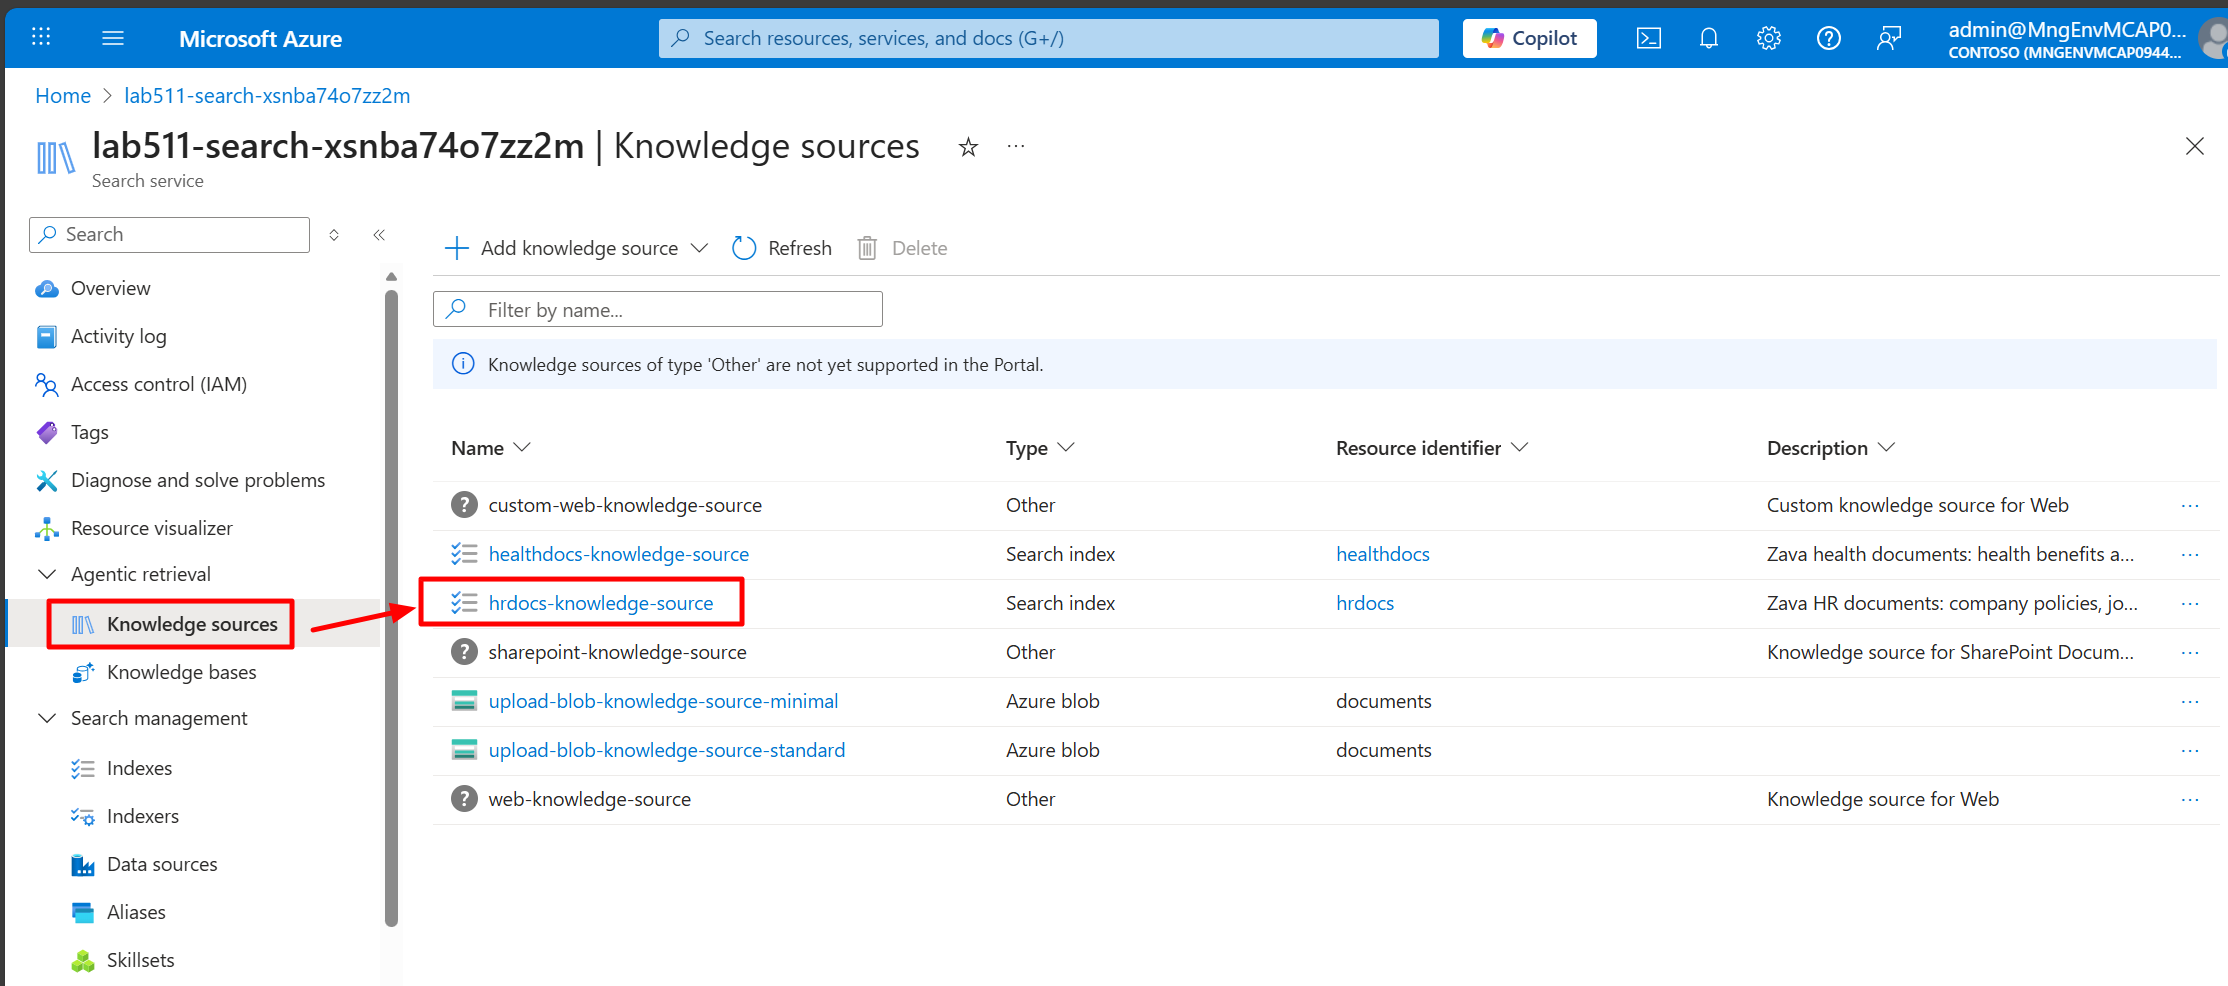

In [16]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import SearchIndexFieldReference, SearchIndexKnowledgeSource, SearchIndexKnowledgeSourceParameters

ks = SearchIndexKnowledgeSource(
    name=knowledge_source_name,
    description="Knowledge source for HR Docs Knowledge",
    search_index_parameters=SearchIndexKnowledgeSourceParameters(
        search_index_name="hrdocs",
        source_data_fields=[SearchIndexFieldReference(name="blob_path"), SearchIndexFieldReference(name="snippet")]
    ),
)

index_client = SearchIndexClient(endpoint=endpoint, credential=credential)
index_client.create_or_update_knowledge_source(knowledge_source=ks)
print(f"Knowledge source '{knowledge_source_name}' created or updated successfully.")

Knowledge source 'hrdocs-knowledge-source' created or updated successfully.


## 단계 3: HR 문서 지식 베이스 생성

**지식 베이스**는 다음을 결합하는 오케스트레이션 레이어입니다:

1. 데이터 소스 (단계 2에서 방금 생성한 지식 소스)
2. 쿼리 이해 및 답변 생성을 위한 AI 모델 (Azure OpenAI)
3. 쿼리 처리 및 응답 형식 지정 방법에 대한 구성

`output_mode=ANSWER_SYNTHESIS`는 지식 베이스가 원시 검색 결과를 반환하는 대신 AI 모델을 사용하여 검색된 문서에서 자연어 답변을 합성하도록 지시합니다. LLM이 어떤 정보가 관련 있는지와 어떻게 표현할지를 결정합니다.

지식 베이스를 지식 소스(데이터)와 AI 모델(추론 엔진)을 사용하여 질문에 답하는 지능형 에이전트로 생각하세요.

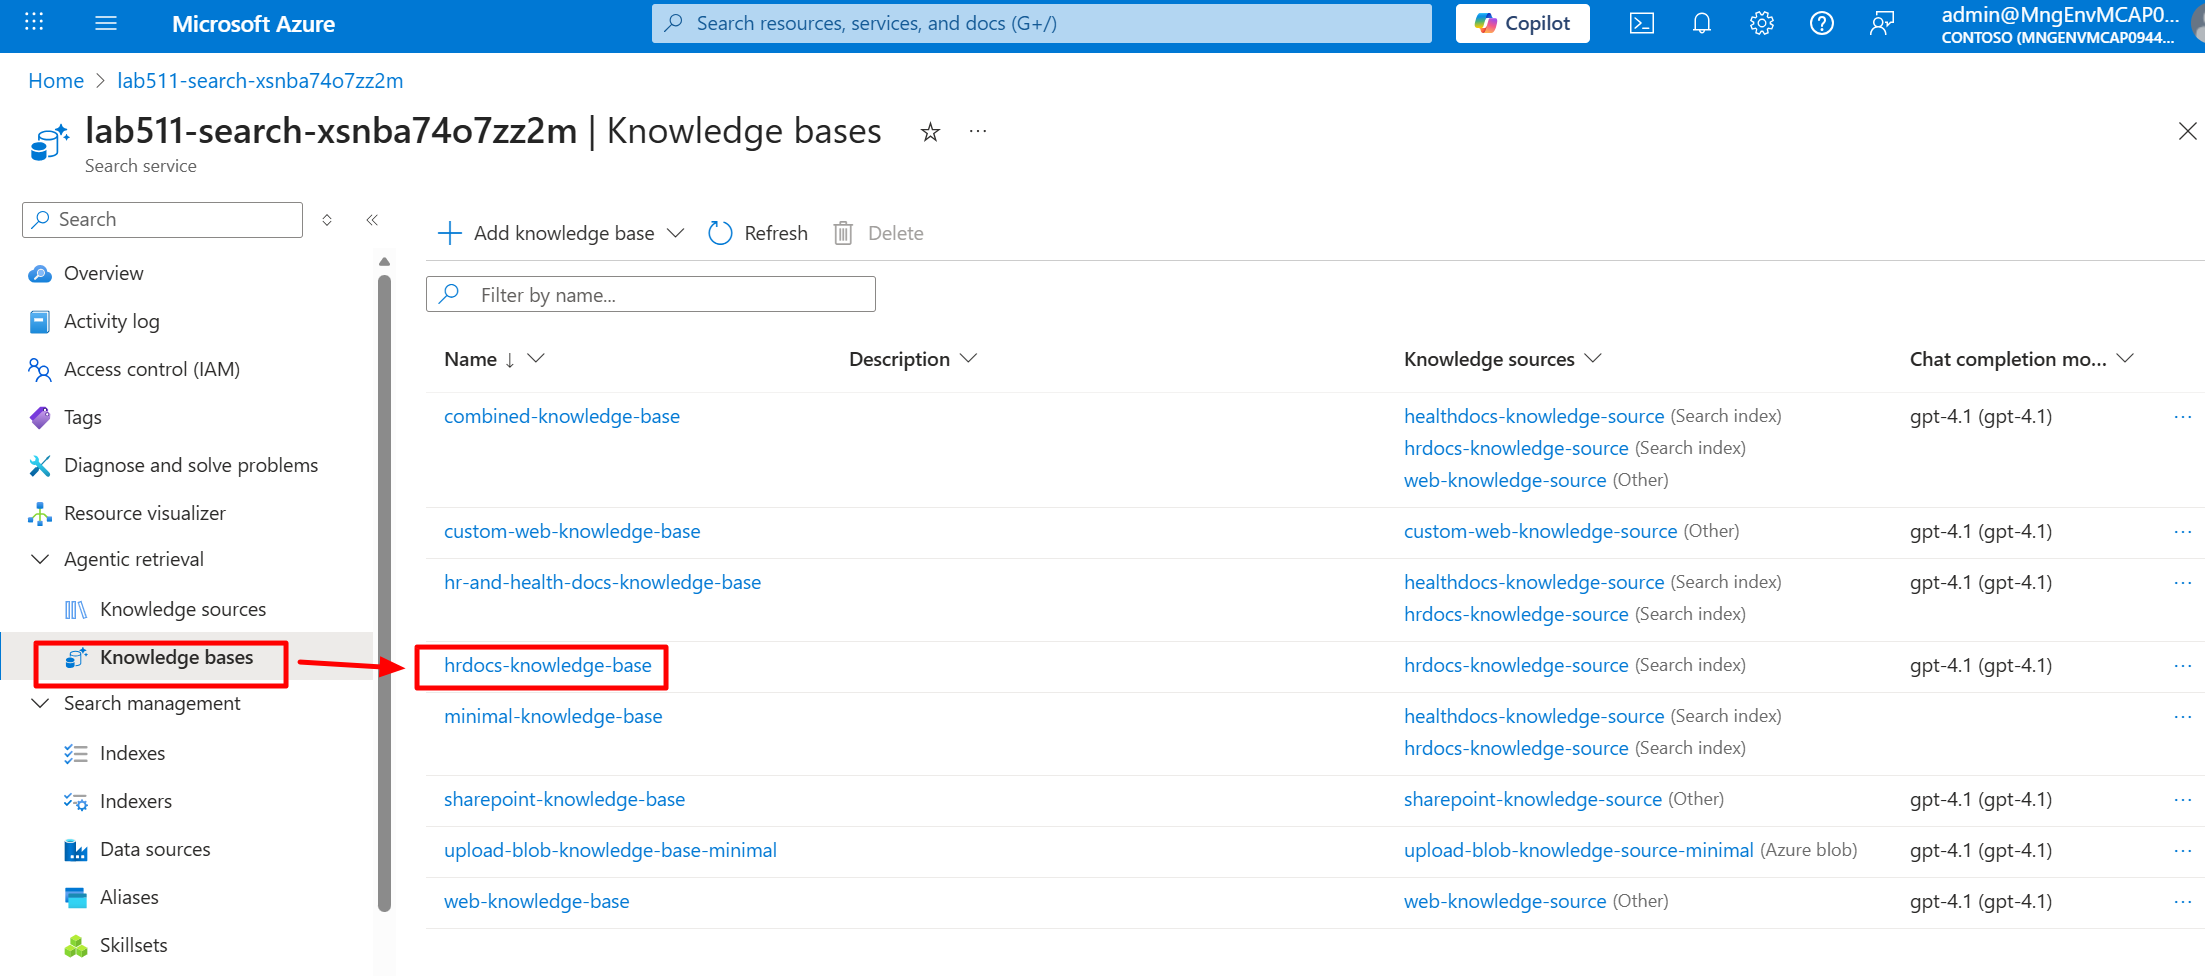

In [17]:
from azure.search.documents.indexes.models import AzureOpenAIVectorizerParameters, KnowledgeBase, KnowledgeBaseAzureOpenAIModel, KnowledgeRetrievalOutputMode, KnowledgeSourceReference

aoai_params = AzureOpenAIVectorizerParameters(
    resource_url=azure_openai_endpoint,
    deployment_name=azure_openai_chatgpt_deployment,
    model_name=azure_openai_chatgpt_model_name,
    api_key=azure_openai_key
)

knowledge_base = KnowledgeBase(
    name=knowledge_base_name,
    models=[KnowledgeBaseAzureOpenAIModel(azure_open_ai_parameters=aoai_params)],
    knowledge_sources=[
        KnowledgeSourceReference(
            name=knowledge_source_name
        )
    ],
    output_mode=KnowledgeRetrievalOutputMode.ANSWER_SYNTHESIS
)

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")

Knowledge base 'hrdocs-knowledge-base' created or updated successfully.


## 단계 4: 에이전틱 검색을 사용하여 결과 가져오기

이제 지식 베이스를 쿼리할 준비가 되었습니다. 쿼리를 보내면 지식 베이스는 단순한 검색을 수행하지 않습니다. 대신:

1. 전체 대화를 분석하여 사용자의 정보 요구를 추론합니다.

1. 쿼리를 집중된 하위 쿼리로 분해합니다.

1. 지식 소스에 대해 하위 쿼리를 동시에 실행합니다.

1. 시맨틱 랭커를 사용하여 결과를 재순위 및 필터링합니다.

1. 상위 결과를 자연어 답변으로 합성합니다.

아래에서 설정하는 매개변수가 이 동작을 제어합니다:
- `include_references=True`: 어떤 문서가 사용되었는지 보여주는 인용 반환
- `include_reference_source_data=True`: 참조뿐만 아니라 실제 텍스트 스니펫 포함
- `always_query_source=True`: 모델이 답을 알고 있다고 생각해도 항상 인덱스 검색
- `include_activity=True`: 에이전트가 수행한 작업의 상세 활동 로그 표시

아래 코드를 실행하여 "What is the responsibility of the Zava CEO?"라고 물어보고 에이전트가 이 쿼리를 어떻게 처리하는지 살펴봅시다.

In [19]:
from azure.search.documents.knowledgebases import KnowledgeBaseRetrievalClient
from azure.search.documents.knowledgebases.models import KnowledgeBaseMessage, KnowledgeBaseMessageTextContent, KnowledgeBaseRetrievalRequest, SearchIndexKnowledgeSourceParams

knowledge_base_client = KnowledgeBaseRetrievalClient(endpoint=endpoint, knowledge_base_name=knowledge_base_name, credential=credential)

req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="Zava CEO의 책임은 무엇인가요?")])
    ],
    knowledge_source_params=[
        SearchIndexKnowledgeSourceParams(
            knowledge_source_name=knowledge_source_name,
            include_references=True,
            include_reference_source_data=True,
            always_query_source=True
        )
    ],
    include_activity=True
)

result = knowledge_base_client.retrieve(retrieval_request=req)
print(f"Retrieved content from '{knowledge_base_name}' successfully.")

Retrieved content from 'hrdocs-knowledge-base' successfully.


## 단계 5: 응답, 참조, 활동 로그 검토

지식 베이스는 세 가지 핵심 정보를 반환합니다:

1. **응답**: 질문에 대한 합성된 자연어 답변
2. **참조**: 답변 생성에 사용된 문서와 텍스트 스니펫을 보여주는 인용
3. **활동 로그**: 에이전틱 검색 프로세스의 상세 추적 - 어떤 하위 쿼리가 생성되었는지, 어떤 소스가 검색되었는지, 결과가 어떻게 순위 지정되었는지 등

이러한 출력을 검토하면 다음에 도움이 됩니다:
- **신뢰**: 답변이 정확히 어디서 왔는지 확인 (투명성)
- **디버그**: 특정 소스가 사용되었거나 사용되지 않은 이유 이해
- **최적화**: 지식 베이스 구성을 조정하는 방법 학습

아래 셀을 실행하여 각 구성 요소를 살펴봅니다.

In [20]:
from IPython.display import display, Markdown

display(Markdown(result.response[0].content[0].text))

Zava의 CEO(Chief Executive Officer)는 회사의 전략적 방향과 감독을 제공하여 장기적인 성공과 수익성을 보장하는 역할을 담당합니다. 주요 책임에는 회사의 재정적 성공과 장기 성장을 위한 전략 및 목표 개발 및 실행, 임원 팀에 대한 전략적 지침 제공 및 회사의 일상 운영 관리, 모든 법률 및 규정 준수 보장, 마케팅 및 광고 전략 개발 감독, 주요 이해관계자와의 관계 개발 및 관리, 대외 행사에서 회사 대표, 공급업체 및 벤더와의 계약 관리 및 협상, 업계 동향 모니터링 및 성장 기회 식별, 긍정적인 회사 문화 조성 등이 포함됩니다. 또한, CEO는 비즈니스 또는 관련 분야의 학사 학위와 10년 이상의 임원 경영 경험, 팀 리더십 및 관리 성공 경험, 뛰어난 문제 해결 및 분석 능력, 우수한 커뮤니케이션 및 대인 관계 능력, 전략적 의사결정 능력, 비즈니스 재무 및 운영, 업계 동향에 대한 지식이 요구됩니다[ref_id:3].

In [21]:
import json

references = json.dumps([ref.as_dict() for ref in result.references], indent=2)
print(references)

[
  {
    "type": "searchIndex",
    "id": "0",
    "activity_source": 2,
    "source_data": {
      "uid": "810256edf976_aHR0cHM6Ly9tYWdvdHRlaWFkbHNnZW4yLmJsb2IuY29yZS53aW5kb3dzLm5ldC9sYWJkb2NzL3JvbGVfbGlicmFyeS5wZGY1_pages_1",
      "blob_path": "/hrdocs/role_library.pdf",
      "snippet": "\u2022 Bachelor\u2019s degree in business or related field \n\n\u2022 10+ years of experience in executive management \n\n\u2022 Proven success in leading and managing a team \n\n\u2022 Strong problem-solving and analytical skills \n\n\u2022 Excellent communication and interpersonal skills \n\n\u2022 Ability to make strategic decisions \n\n\u2022 Knowledge of business finances \n\n\u2022 Knowledge of business operations \n\n\u2022 Knowledge of industry trends \n\n\u2022 Knowledge of applicable laws and regulations \n\n  \n\n\n\nChief Operating Officer \n\nJob Title: Chief Operating Officer \n\nCompany: Zava \n\nLocation: Any major city \n\nPosition Summary: \n\nThe Chief Operating Officer (COO) at

In [22]:
import pandas as pd

activity_types = [{"type": a.type} for a in result.activity]

df = pd.DataFrame(activity_types)

print("Activity Log Steps")
df

Activity Log Steps


,type
0,modelQueryPlanning
1,searchIndex
2,searchIndex
3,searchIndex
4,agenticReasoning
5,modelAnswerSynthesis


In [23]:
activity_content = json.dumps([a.as_dict() for a in result.activity], indent=2)
print("Activity Details")
print(activity_content)

Activity Details
[
  {
    "id": 0,
    "type": "modelQueryPlanning",
    "elapsed_ms": 1767,
    "input_tokens": 1455,
    "output_tokens": 60
  },
  {
    "id": 1,
    "type": "searchIndex",
    "elapsed_ms": 1536,
    "knowledge_source_name": "hrdocs-knowledge-source",
    "query_time": "2026-01-22T07:06:15.592Z",
    "count": 17,
    "search_index_arguments": {
      "search": "Zava CEO\uc758 \ucc45\uc784",
      "source_data_fields": [
        {
          "name": "snippet"
        },
        {
          "name": "uid"
        },
        {
          "name": "blob_path"
        }
      ],
      "search_fields": [],
      "semantic_configuration_name": "semantic-configuration"
    }
  },
  {
    "id": 2,
    "type": "searchIndex",
    "elapsed_ms": 385,
    "knowledge_source_name": "hrdocs-knowledge-source",
    "query_time": "2026-01-22T07:06:15.987Z",
    "count": 15,
    "search_index_arguments": {
      "search": "Zava CEO \uc5ed\ud560",
      "source_data_fields": [
        {
   

## 요약

파트 1을 완료했습니다! 🎉 지식 소스를 생성하고, Azure OpenAI로 지식 베이스를 구축하며, 에이전틱 검색을 실행하여 인용이 포함된 답변을 얻었습니다.

**기억해야 할 핵심 개념:**
- 지식 소스는 데이터(인덱스, SharePoint, 웹, blob)에 연결됩니다
- 지식 베이스는 AI 모델과 데이터 소스를 오케스트레이션합니다
- 에이전틱 검색은 쿼리에 대해 추론하고 근거 있는 답변을 합성합니다
- 활동 로그는 에이전트가 쿼리를 어떻게 처리했는지 보여줍니다

➡️ [파트 2: 다중 지식 소스](part2-multiple-knowledge-sources.ipynb)로 계속하여 여러 인덱스를 쿼리하고 소스 선택을 제어하는 방법을 배웁니다.